In [ ]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

print(current_datetime)

# Spatio Temporal Logistic
This notebook is the first test of a spatio temporal logistic to link properly the **built-up surface** of a given region depending on its quality of life (**GDP/cap**) and of its **population density**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Region import Region
import pandas as pd
import os

## Part 0 : Theory
First we define some classical functions that will be used later for our modelisation.

### The logistic function
$f(t) = \frac{S}{1+e^{(-k(t-t_0))}}$

with: 
- *S* : the saturation level
- *k* : the slope
- $t_0$ : the half height value (left right alignement).

The logistic function serves as a predictive equation and as the motor of our dynamical models. Indeed, we observe that at the country scale, as time passes, the GDP/cap increases and some observables as the number of cars or as the number of m2/cap. This means that the quality of life, and thus the stocks consumed by a region improve. But this exponential growth does not increase indefinetely. A saturation is observed even if the GDP/cap still increase. This is explained because people usually do not own 2 or 3 cars even though they possess the money to. An logistic function, also known as the S curve, is a way to model this observation.

### The exponential decay function
$f(x) = a\, e^{-b\,x}+c$

with:
- *a* : the slope
- *b* : the half-life ?
- *c* : the bias.

The exponential decay is a decreasing exponential observed in nature (for example for the probability of nuclear decay over time). This is one of our assumption to model the decreasing phenomena observed betwenn the **built-up surface/cap** and the **population density** of a region.

### The reciprocal function
$f(x) = \frac{a}{x} + b$

with:
- *a* :
- *b* : the bias.

The reciprocal function is another asumption as this function is also a decreasing one, but it turned out to be less fitted for our data.

In [2]:
def logistic(x, a, b, c):
    return a / (1 + np.exp(-b*(x-c)))

def exponential_decay(X, a, b, c):
    return a * np.exp(-b * X) + c

def reciprocal(X, a, b):
    return (a / X) + b

### The Spatio Temporal Logistic function
$f(t,x) = \frac{a\,e^{-b\,x}+c}{1 + e^{(-k(t-t_0))}}$

The Spatio Temporal Logistic function (**STL**) is the mix between our classical logistic expression and the exponential decay as S (the saturation level).

In [3]:
def STL(X, a, b, c, d, e):
    # STL stands for Spatio Temporal Logistic. It is an refinment of a logistic, dependant on time (here the GDP per capita serves 
    # as proxy for time), with a saturation level which is a function of space (here the population density of a region)
    x1, x2 = X
    saturation = exponential_decay(x2, a, b,c)
    return saturation / (1 + np.exp(-d*(x1-e)))

## PART 1 : Initialisation
Initialisation of the analysis parameters.

- **region_names** : (*string*) the country to study, named by their ISO3 
- **years** : (*string*) years to study
- **raster_S** : (*string*) letter used in the **GHSL** dataset (S, S_NRES, POP, ...)
- **lvl** : (*int*) the level of our administrative data (GDP and population)
- **subregion_borders** : (*string*) the path to administrative border shapefile to cut the subregions 
- **i dentifier** : (*string*) the column name to match the region names between the administrative data and the GIS data

To each region is associated a **DataFrame** (*oecd_DF_merged*) with the subregions matching administrative observables (GDP, population, etc).

In [4]:
lvl = 2

In [5]:
# Make the OECD complete DF
oecd_gdp_per_cap_file = r"/data/mineralogie/hautervo/data/OECD/GDP per capita/TL" + str(lvl) + r"/Gross Domestic Product per capita, in USD.csv"
oecd_population_file = r"/data/mineralogie/hautervo/data/OECD/Population/TL" + str(lvl) + r"/Resident population.csv"

oecd_gdp_per_capita_df = pd.read_csv(oecd_gdp_per_cap_file, skiprows=0, header=1)
oecd_population_df = pd.read_csv(oecd_population_file, skiprows=0, header=1)

df_list = []
df_list.append(oecd_gdp_per_capita_df)
df_list.append(oecd_population_df)

subregion_col = "tl"+str(lvl)+"_id"
parent_col = "iso3"

for df in df_list:
    df[subregion_col] = df["Code"]

In [6]:
# The OECD admin units

oecd_admin_units = "/data/mineralogie/hautervo/data/OECD/admin_units/TL" + str(lvl) + "/OECD_TL" + str(lvl) + "_2020.shp"

In [7]:
# Countries to ignore from our study (too big)
country_to_pop = ["AUS", "USA"]
country_to_pop = []

In [8]:
regions_names = list(oecd_gdp_per_capita_df["Country"].unique())

#exclude the countries
for c in country_to_pop:
    regions_names.pop(regions_names.index(c))

# regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "LUX", "ESP", "USA", "JPN", "CAN", "AUS"] # to remove
# regions_names = ["FRA", "DEU"] # to remove
#regions_names = ["BEL"]

print(regions_names, "\n")

# years = ["1975", "1990", "2000", "2010", "2020"] # FRA
# years = ["1990", "2010", "2020"] # DEU
years = ["2000", "2010", "2020"]
#years = ["2020"]

raster_str = "S"

regions = []

for name in regions_names:
    new_region = Region(name, lvl-1)
    regions.append(new_region)

    for y in years:        
        new_region.add_gis("/data/mineralogie/hautervo/data/GHSL/Built_"+ raster_str + "/E" + y + "_100m_Global/subregions/" + name + ".tif", name + "_" + y, str(y), lvl-1) 



['BEL'] 

Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2000_100m_Global/subregions/BEL.tif  added to region  BEL
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2010_100m_Global/subregions/BEL.tif  added to region  BEL
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2020_100m_Global/subregions/BEL.tif  added to region  BEL


In [9]:
output_df_path = "/data/mineralogie/hautervo/data/Outputs/GHSL/Built_" + raster_str + "/OECD/TL" + str(lvl) + "/"

## PART 2 : Computation of the observables
Now that we define all the parameters of our study, we will cut the regions into their respective subregions (*make_subregions*). 

We then compute for each subregions GIS, the geographical observables that we store in its oecd_DF_merged.

In [10]:
#### Get the computed observables
force_recompute = False
for region in regions:
    region.make_subregions(oecd_admin_units, subregion_col, parent_col)
    for subregion in region.subregions:
        csv_path = os.path.join(output_df_path, region.name, subregion.name, '_'.join(years))+".csv"
        if not os.path.isfile(csv_path) or force_recompute:
            subregion.output_df = pd.DataFrame(data=years, columns=["year"])

            for y in years:
                gis = subregion.gis_list[years.index(y)]
    
                subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface GHSL"] = gis.get_total_sum_pixel_values()
                subregion.output_df.loc[subregion.output_df["year"]==y, "Total surface"] = 1e4 * gis.get_total_number_pixels() 
                subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface fraction"] = subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface GHSL"] / subregion.output_df.loc[subregion.output_df["year"]==y, "Total surface"]

                try:
                    subregion.output_df.loc[subregion.output_df["year"]==y, "GDP per capita"] = oecd_gdp_per_capita_df.loc[oecd_gdp_per_capita_df[subregion_col]==subregion.name, y].values[0]
                except:
                    print("Missing: ", subregion.name, " ", y, " GDP per capita.")
                
                try:
                    subregion.output_df.loc[subregion.output_df["year"]==y, "Population"] = oecd_population_df.loc[oecd_population_df[subregion_col]==subregion.name, y].values[0]                    
                    subregion.output_df.loc[subregion.output_df["year"]==y, "Population/Total surface"] = subregion.output_df.loc[subregion.output_df["year"]==y, "Population"] / subregion.output_df.loc[subregion.output_df["year"]==y, "Total surface"]
                    # output
                    subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface GHSL/Population"] = subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface GHSL"] / subregion.output_df.loc[subregion.output_df["year"]==y, "Population"]
                except:
                    print("Missing: ", subregion.name, " ", y, " Population.")

            # save the new df
            os.makedirs(os.path.dirname(csv_path), exist_ok="True")
            subregion.output_df.to_csv(csv_path, index=False)
        else:
            #use a precomputed csv
            subregion.output_df = pd.read_csv(csv_path)

Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2000_100m_Global/subregions/BEL/subregions/BE2.tif  added to region  BE2
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2010_100m_Global/subregions/BEL/subregions/BE2.tif  added to region  BE2
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2020_100m_Global/subregions/BEL/subregions/BE2.tif  added to region  BE2
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2000_100m_Global/subregions/BEL/subregions/BE3.tif  added to region  BE3
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2010_100m_Global/subregions/BEL/subregions/BE3.tif  added to region  BE3
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2020_100m_Global/subregions/BEL/subregions/BE3.tif  added to region  BE3
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2000_100m_Global/subregions/BEL/subregions/BE1.tif  added to region  BE1
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2010_100m_Global/subregions/BEL/subregions/BE1.tif  added

In [11]:
#regions[-1].subregions[-1].output_df

## PART 3 : First analysis and plots
Here we can, if we want or need to, filter some subregions from our study. 

Thus, we can plot our observables.

In [12]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')

colors_reg = [
    "black", "red", "peru", "darkorange", "gold", "purple", "magenta", 
    "yellow", "chartreuse", "turquoise", "darkcyan", "deepskyblue", 
    "blue", "orange", "green", "brown",
    # Additional colors
    "crimson", "lime", "orchid", "coral", "navy", "teal", "darkred", 
    "salmon", "plum", "seagreen", "midnightblue", "lightseagreen", 
    "dodgerblue", "sienna", "hotpink", "darkviolet", "lightcoral", 
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#a6cee3", "#1f78b4", 
    "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", 
    "#cab2d6", "#6a3d9a", "#ffff99", "#b15928", "#6b6ecf", "#9c9ede", 
    "#31a354", "#74c476", "#a1d99b", "#d9d9d9", "#636363", "#969696"
]

### PLOT 1.1 : Total observable compared to time

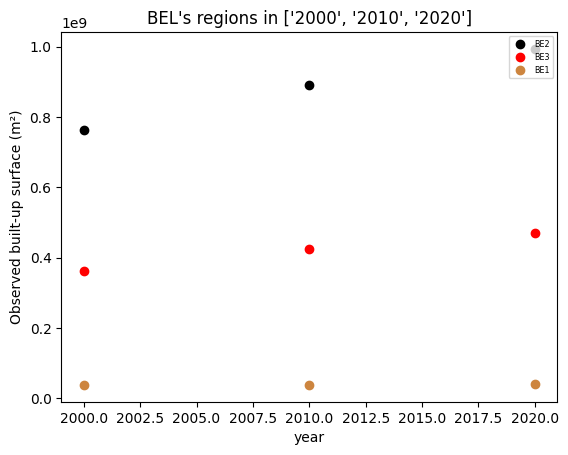

In [13]:
x_col = "year"
y_col = "Built up surface GHSL"

for region in regions:
    k = 0
    for subregion in region.subregions:
        filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
        x = filtered_df[x_col]
        y = filtered_df[y_col]
 
        plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

        k = k + 1

    plt.title(region.name + "'s regions in " + str(years))
    plt.ylabel("Observed built-up surface (m²)")
    plt.xlabel("year")
    plt.legend(loc="upper right", prop=fontP)
    plt.show()

### PLOT 1.2 : Observable per capita compared to time

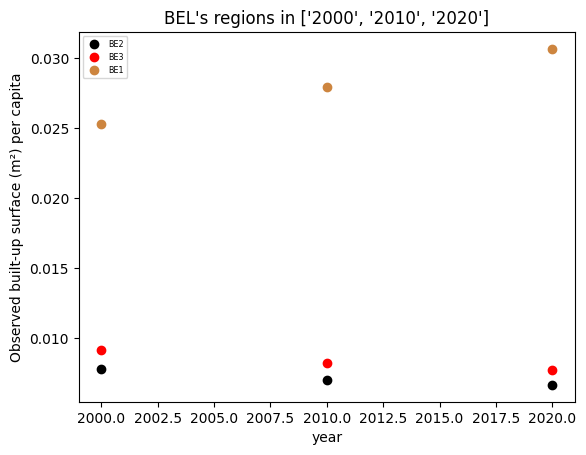

In [14]:
x_col = "year"
y_col = "Built up surface GHSL/Population"

for region in regions:
    k = 0
    for subregion in region.subregions:
        filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
        x = filtered_df[x_col]
        y = filtered_df[y_col]
 
        plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

        k = k + 1

    plt.title(region.name + "'s regions in " + str(years))
    plt.ylabel("Observed built-up surface (m²) per capita")
    plt.xlabel("year")
    plt.legend(loc="upper left", prop=fontP)
    plt.show()

### PLOT 2.1 : Total observable compared to GDP

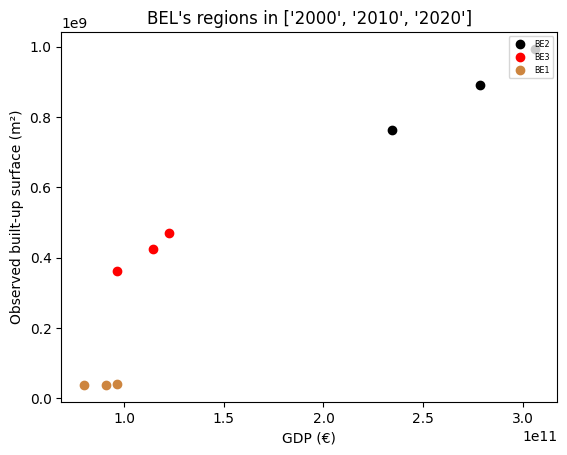

In [15]:
x_col1 = "GDP per capita"
x_col2 = "Population"
y_col = "Built up surface GHSL"

for region in regions:
    k = 0
    for subregion in region.subregions:
        filtered_df = subregion.output_df.dropna(subset=[x_col1, x_col2, y_col])
        x = filtered_df[x_col1].mul(filtered_df[x_col2]) # TODO how to add year here ?
        y = filtered_df[y_col]

        plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

        k = k + 1

    plt.title(region.name + "'s regions in " + str(years))
    plt.ylabel("Observed built-up surface (m²)")
    plt.xlabel("GDP (€)")
    plt.legend(loc="upper right", prop=fontP)
    plt.show()

### PLOT 2.2 : Observable per capita compared to GDP per capita

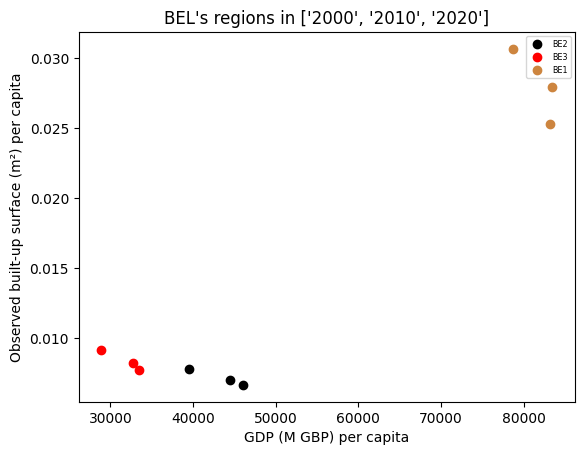

In [16]:
x_col = "GDP per capita"
y_col = "Built up surface GHSL/Population"

for region in regions:
    k = 0
    for subregion in region.subregions:
        filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
        x = filtered_df[x_col]
        y = filtered_df[y_col]
 
        plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

        k = k + 1

    plt.title(region.name + "'s regions in " + str(years))
    plt.ylabel("Observed built-up surface (m²) per capita")
    plt.xlabel("GDP (M GBP) per capita")
    plt.legend(loc="upper right", prop=fontP)
    plt.show()

### PLOT 3.1 : Observable per capita compared to observable fraction (m2 built up / all m2)

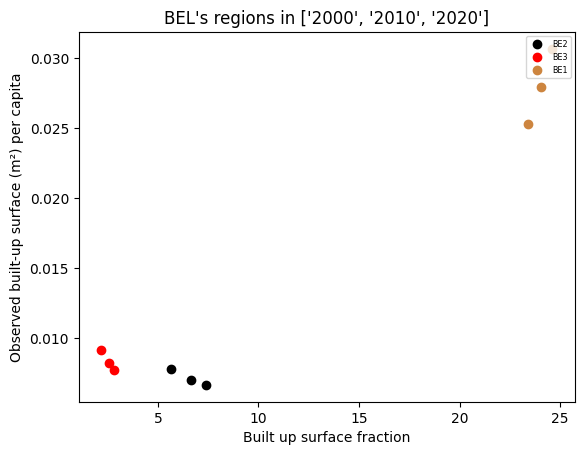

In [17]:
x_col = "Built up surface fraction"
y_col = "Built up surface GHSL/Population"

for region in regions:
    k = 0
    for subregion in region.subregions:
        filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
        x = filtered_df[x_col]
        y = filtered_df[y_col]
 
        plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

        k = k + 1

    plt.title(region.name + "'s regions in " + str(years))
    plt.ylabel("Observed built-up surface (m²) per capita")
    plt.xlabel("Built up surface fraction")
    plt.legend(loc="upper right", prop=fontP)
    plt.show()

### PLOT 3.2 : Observable per capita compared to population density

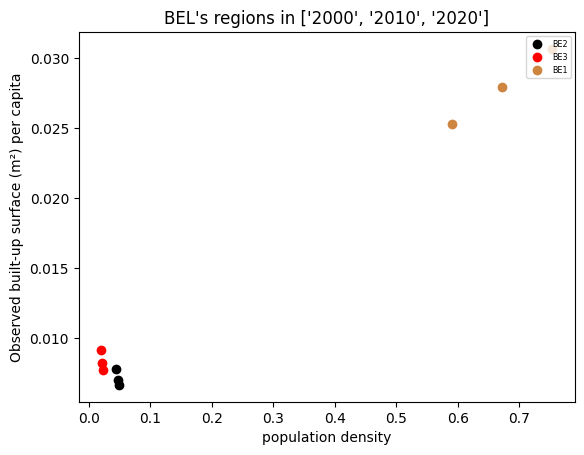

In [18]:
x_col = "Population/Total surface"
y_col = "Built up surface GHSL/Population"

for region in regions:
    k = 0
    for subregion in region.subregions:
        filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
        x = filtered_df[x_col]
        y = filtered_df[y_col]
 
        plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
    
        k = k + 1

    plt.title(region.name + "'s regions in " + str(years))
    plt.ylabel("Observed built-up surface (m²) per capita")
    plt.xlabel("population density")
    plt.legend(loc="upper right", prop=fontP)
    plt.show()

## PART 4 : Fitting

The fitting part consists of several parts. We do the fits in seperate steps for two reasons. First because the fits are better if we feed it with coherent initial parameter values. Secondly because it is best for us to get a clear picture of what are fitted functions look like.

1. We fit the classical logistic part only (observable/cap vs GDP/cap) region by region to get an idea of appropriate fit parameter values.

2. We fit the exponential decay part only (observable/cap vs population density) for one year to get an idea of appropriate fit parameter values.

3. We fit the Spatio Temporal Logistic function. In order to have better results, we start the fitting algorithm with initial parameter values close to the one found in the first two step described above.

4. 

In [19]:
from Fit import Fit

#### PART 4.1 : Fit the logistic only

In [21]:
# # fit logistic over time, region by region
# logistic_fit_handler = []
# for region in regions:
#     print(region.name, "\n")
#     for subregion in region.subregions:
#         # df_gdp_cap = []
#         # df_built_up = []
#         # for i in range(len(years)):
#             # df_gdp_cap.append(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "GDP per capita"].values[0])
#             # df_built_up.append(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Built up surface GHSL"].div(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population"]).values[0])
        
#         logistic_fit_handler.append(Fit(subregion, subregion.output_df["GDP per capita"], [0,0], subregion.output_df["Built up surface GHSL"]))
#         logistic_fit_handler[-1].fit_logistic(init=[180, 0.00000001, 20000])

#         print(subregion.name, " ", logistic_fit_handler[-1].fitted_params)
#         print(subregion.name, " R squared ", ": ", logistic_fit_handler[-1].r_squared)

In [22]:
# # PLOT verification
# colors_reg = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "r", "g", "y", "b", ""]
# colors_reg = ["black", "red", "peru", "darkorange", "gold", "purple", "magenta", "yellow", "chartreuse", "turquoise", "darkcyan", "deepskyblue", "blue", "orange", "green", "brown"]

# j=0
# for region in regions:
#     x = np.linspace(min(region.df_list[0].df["GDP per capita"]), max(region.df_list[len(years)-1].df["GDP per capita"]),100)
#     k = 0
#     for subregion in region.subregions:
#         for i in range(len(years)):
#             if i == len(years) -1:
#                 plt.scatter(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"GDP per capita"], region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"Built up surface GHSL"]/ region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population"],  color=colors_reg[k % len(colors_reg)],
#                         label=subregion.name) #, alpha=(i+1)/6)
#                 plt.plot(x, logistic(x, logistic_fit_handler[j].fitted_params[0], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2]), color=colors_reg[k % len(colors_reg)], alpha=.4)
#             else:
#                 plt.scatter(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "GDP per capita"], region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"Built up surface GHSL"]/region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population"],  color=colors_reg[k % len(colors_reg)],
#                         )#alpha=(i+1)/6)
#         k = k + 1
#         j = j + 1

#     plt.title(region.name + "'s regions in " + str(years))
#     plt.ylabel("Observed built-up surface (m²) per capita")
#     plt.xlabel("GDP (M GBP) per capita")
#     plt.legend(loc="upper right", prop=fontP)
#     plt.show()

#### PART 4.2 : Fit the saturation only

In [23]:
# # fit the saturation fct for one year
# saturation_fit_handler = []
# ii = len(years)-1

# for region in regions:
#     # fit reciprocal
#     saturation_fit_handler.append(Fit(years[-1], region.df_list[ii].df["Population/Total surface"], [0,0], region.df_list[ii].df["Built up surface GHSL"].div(region.df_list[ii].df["Population"])))
#     saturation_fit_handler[-1].fit_reciprocal(init=[.05, 50])
#     print("\n",region.name, " ", saturation_fit_handler[-1].fitted_params)
#     print("R squared for ", years[i], ": ", saturation_fit_handler[-1].r_squared)

#     # fit exp decay
#     saturation_fit_handler.append(Fit(years[-1], region.df_list[ii].df["Population/Total surface"], [0, 0], region.df_list[ii].df["Built up surface GHSL"].div(region.df_list[ii].df["Population"])))
#     saturation_fit_handler[-1].fit_exponential_decay(init=[300, 100, 75])
#     print("\n",region.name, " ", saturation_fit_handler[-1].fitted_params)
#     print("R squared for ", years[i], ": ", saturation_fit_handler[-1].r_squared)


In [24]:
# #  PLOT verification
# j = 0
# for region in regions:
#     k = 0
#     for subregion in region.subregions:
#         plt.scatter(region.df_list[-1].df.loc[region.df_list[-1].df[region.subregion_col]==subregion.name, "Population/Total surface"], region.df_list[-1].df.loc[region.df_list[-1].df[region.subregion_col]==subregion.name,"Built up surface GHSL"]/ region.df_list[-1].df.loc[region.df_list[-1].df[region.subregion_col]==subregion.name, "Population"],  color=colors_reg[k % len(colors_reg)],
#                 label=subregion.name, alpha=0.5)
#         k = k + 1
        
#     plt.plot(saturation_fit_handler[j].x1_fit, saturation_fit_handler[j].y_fit, label="reciprocal", color="b") # exp
#     plt.plot(saturation_fit_handler[j+1].x1_fit, saturation_fit_handler[j+1].y_fit, label="exponential decay", color="g") # rec
#     j = j + 2 # because there is two plots
#     plt.xlabel("population density")
#     plt.legend(loc="upper right")
#     plt.title(region.name)
#     plt.show()

#### PART 4.3 : Fit of the Spatio Temporal Logistic function

Now that we have an idea of the parameters and their fitness we can derive parameters for the Spatio Temporal Logistic function as a whole. For this, we concatenate all our points, all regions, all years.

In [52]:
# # Concatenate all the data points
STL_fit_handler = []

df_gdp_cap_region_handler = []
df_pop_density_region_handler = []
df_built_up_region_handler = []

x_col1 = "GDP per capita"
x_col2 = "Population/Total surface"
y_col = "Built up surface GHSL/Population"

for region in regions:
    df_gdp_cap_region = []
    df_pop_density_region = []
    df_built_up_region = []

    for subregion in region.subregions:
        filtered_df = subregion.output_df.dropna(subset=["year", x_col1, x_col2, y_col])
        df_gdp_cap_region = df_gdp_cap_region + filtered_df[x_col1].to_list()
        df_pop_density_region = df_pop_density_region + filtered_df[x_col2].to_list()
        df_built_up_region = df_built_up_region + filtered_df[y_col].to_list()      


    df_gdp_cap_region_handler.append(df_gdp_cap_region)
    df_pop_density_region_handler.append(df_pop_density_region)
    df_built_up_region_handler.append(df_built_up_region)
print(df_built_up_region_handler)

[[0.0077920208379146, 0.0070104835040648, 0.0066799443650719, 0.0091886912940003, 0.0082608515266617, 0.0077629215010511, 0.0252760406443122, 0.027906203355834, 0.0306347763759737]]


In [51]:
# fit STL logistic with density
for i in range(len(regions)):
    STL_fit_handler.append(Fit("tmp", np.array(df_gdp_cap_region_handler[i]), np.array(df_pop_density_region_handler[i]), np.array(df_built_up_region_handler[i])))
    STL_fit_handler[-1].fit_STL(init=[186, 30, 745, 0.0001, 30000])

    print(regions[i].name)
    print("Final STL fct")
    print("R squared for ", ": ", STL_fit_handler[-1].r_squared)
    print(STL_fit_handler[-1].fitted_params)
    print("")

        

BEL
Final STL fct
R squared for  :  -23420.537982168476
[257.0106855204602, 305.504294767722, 27.03756241523342, 0.00020035147160303707, 93693.74457180366]



#### PART 4.4 : Store the values

At this step, we successfully fitted the function STL to all our available data. But, as we may want to use different values for the rest of our study, it is good to save the values of the study. For example, if I want to see if the values found on FRA are consistent with data from DEU, I may continue with the fitted parameters of FRA even though my current study is on DEU.

FITTED PARAMETERS:
|  Regions | years  | R²  | Values  | 
|---|---|---|---|
|  FRA | [1975, 1990, 2000, 2010, 2020]  | 0.872  | [379.7504189082203, 34.20651548329122, 53.14129351418502, 7.425803059587641e-05, 26457.87245766918]  |   
| DEU  |  [1990, 2010, 2020] | 0.816  |  [163.33898040560297, 39.972102574099054, 64.25203545135804, 7.831134965918744e-05, 5859.5488263881125] |   
|   |   |   |   |   

In [ ]:
# ###
# # !!!
# # Pay attention to this cell
# # As written above, this will change the parameter values
# ###
# correct_answer = False
# default_fit = [379.7504189082203, 34.20651548329122, 53.14129351418502, 7.425803059587641e-05, 26457.87245766918] # these are the FRA values
# default_fit_meta = "FRA values"

# while not correct_answer:
#     value = input(f"Question:\nDo you want to change the STL_fit_handler[j].fitted_params to default ones? They may differ from the ones computed on {regions_names}. Answer: y/n")
#     if value=="y":
#         STL_fit_handler[j].fitted_params = default_fit
#         print(f"You answered yes, the code goes one with {default_fit_meta}:\n{default_fit}")
#         correct_answer = True
#     elif value=="n":
#         print(f"You answered no, the code goes on with the computed values on {regions_names}.")
#         correct_answer = True
#     else:
#         print("The answer was not understood, please answer y or n.")
#         correct_answer = False

In [ ]:
# # PLOT verification

# j = -1
# for region in regions:
#     j = j + 1 #I put it here because it is easier to read than the end of the loop
#     x1 = 27000 # fixed GDP/cap
#     x2 = 0.1 # fixed pop density

#     # with gdp per capita
#     k = 0
#     for subregion in region.subregions:
#         for i in range(len(years)):
#             if i == len(years) -1:
#             # if True:
#                 plt.scatter(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"GDP per capita"], region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"Built up surface GHSL"]/ region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population"],  color=colors_reg[k % len(colors_reg)],
#                         label=subregion.name, alpha=0.5)
#                 plt.scatter(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"GDP per capita"], STL([region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"GDP per capita"], x2], STL_fit_handler[j].fitted_params[0], STL_fit_handler[j].fitted_params[1], STL_fit_handler[j].fitted_params[2], STL_fit_handler[j].fitted_params[3], STL_fit_handler[j].fitted_params[4]), color=colors_reg[k % len(colors_reg)], marker='s')
#             else:
#                 pass
#                 # plt.scatter(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "GDP per capita"], region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"Built up surface GHSL"]/region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population"],  color=colors_reg[k % len(colors_reg)],
#                 #         alpha=(i+1)/6)
#         k = k + 1

#     plt.title(region.name + "'s regions in " + str(years))
#     plt.ylabel("Observed built-up surface (m²) per capita")
#     plt.xlabel("GDP (M GBP) per capita")
#     plt.legend(loc="upper right", prop=fontP)
#     plt.show()

#     # with population density
#     k = 0

#     for subregion in region.subregions:
#         for i in range(len(years)):
#             if i == len(years) -1:
#             # if True:
#                 plt.scatter(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population/Total surface"], region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"Built up surface GHSL"]/ region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population"],  color=colors_reg[k % len(colors_reg)],
#                         label=subregion.name, alpha=0.5)
#                 plt.scatter(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population/Total surface"], STL([x1, region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population/Total surface"]], STL_fit_handler[j].fitted_params[0], STL_fit_handler[j].fitted_params[1], STL_fit_handler[j].fitted_params[2], STL_fit_handler[j].fitted_params[3], STL_fit_handler[j].fitted_params[4]), color=colors_reg[k % len(colors_reg)], marker='s')
#             else:
#                 pass
#                 # plt.scatter(region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population/Total surface"], region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name,"Built up surface GHSL"]/region.df_list[i].df.loc[region.df_list[i].df[region.subregion_col]==subregion.name, "Population"],  color=colors_reg[k % len(colors_reg)],
#                 #         alpha=(i+1)/6)
#         k = k + 1

#     plt.title(region.name + "'s regions in " + str(years))
#     plt.ylabel("Observed built-up surface (m²) per capita")
#     plt.xlabel("population density")
#     plt.legend(loc="upper right", prop=fontP)
#     plt.show()

#### PART bonus : enjoy the show

The surface is the fitted Spatio Temporal logistic function.
The points are the data

In [ ]:
import plotly.graph_objects as go

for j in range(len(regions)):
    # Create a meshgrid of x and y values
    x = np.linspace(min(df_gdp_cap_region_handler[j]), max(df_gdp_cap_region_handler[j]), 50)
    y = np.linspace(min(df_pop_density_region_handler[j]), max(df_pop_density_region_handler[j]), 50)
    x_grid, y_grid = np.meshgrid(x, y)
    z = STL([x_grid,y_grid], STL_fit_handler[j].fitted_params[0], STL_fit_handler[j].fitted_params[1], STL_fit_handler[j].fitted_params[2], STL_fit_handler[j].fitted_params[3], STL_fit_handler[j].fitted_params[4])
    cmin = np.min(z)
    cmax = np.max(z)
    
    # Create the surface plot using Plotly
    fig = go.Figure(data=[
        go.Surface(
            z=z, 
            x=x_grid, 
            y=y_grid, 
            colorscale="Turbo", 
            cmin=cmin,
            cmax=cmax,
            opacity=0.4),
        go.Scatter3d(
            x=df_gdp_cap_region_handler[j], y=df_pop_density_region_handler[j], z=df_built_up_region_handler[j],
            mode='markers',  # Use 'markers' for scatter plot
            marker=dict(
                size=6,  # Size of the points
                color=df_built_up_region_handler[j],  # Color of the points
                colorscale='Turbo',  # Colorscale for the points
                cmin=cmin,
                cmax=cmax,
                opacity=1.0
            )
        ),
        
        ]
        )

    # Customize the layout
    fig.update_layout(title=f'3D STL\'s function {regions[j].name}',
                    scene=dict(
                        xaxis_title='GDP per capita',
                        yaxis_title='population density',
                        zaxis_title='m2 per capita'
                    ),
                    width=800, height=700)

    # Show the plot
    fig.show()

The End.

In [ ]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

print(current_datetime)